# Predicting Risk Tolerance of Investors (basis their demographic and investments data)

In [1]:
import numpy as np;
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import copy 
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
#from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

In [2]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 621 kB/s            


## Loading the Data

In [3]:
dataset = pd.read_excel('../input/scfp2009panel/SCFP2009panel.xlsx')

In [4]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
type(dataset)

pandas.core.frame.DataFrame

In [6]:
dataset.shape

(19285, 515)

## Data Preparation and Feature Selection

In [7]:
#Average SP500 during 2007 and 2009
Average_SP500_2007=1478
Average_SP500_2009=948

#Risk Tolerance 2007
dataset['RiskFree07']= dataset['LIQ07'] + dataset['CDS07'] + dataset['SAVBND07'] + dataset['CASHLI07']
dataset['Risky07'] = dataset['NMMF07'] + dataset['STOCKS07'] + dataset['BOND07'] 
dataset['RT07'] = dataset['Risky07']/(dataset['Risky07']+dataset['RiskFree07'])

#Risk Tolerance 2009
dataset['RiskFree09']= dataset['LIQ09'] + dataset['CDS09'] + dataset['SAVBND09'] + dataset['CASHLI09']
dataset['Risky09'] = dataset['NMMF09'] + dataset['STOCKS09'] + dataset['BOND09'] 
dataset['RT09'] = dataset['Risky09']/(dataset['Risky09']+dataset['RiskFree09'])*\
                (Average_SP500_2009/Average_SP500_2007)

In [8]:
dataset2 = copy.deepcopy(dataset)  
dataset.head()

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I,RiskFree07,Risky07,RT07,RiskFree09,Risky09,RT09
0,1,11,11668.134198,47,3,12,2,1,0,2,...,0.0,93.125197,270.403054,57,7994.813847,0.0,0.0,16000,17000,0.330422
1,1,12,11823.456494,47,3,12,2,1,0,2,...,0.0,93.125197,249.593620,57,7994.813847,0.0,0.0,19000,18000,0.312036
2,1,13,11913.228354,47,3,12,2,1,0,2,...,0.0,93.125197,209.233358,57,7984.457871,0.0,0.0,13000,12000,0.307876
3,1,14,11929.394266,47,3,12,2,1,0,2,...,0.0,93.125197,209.273158,57,7984.457871,0.0,0.0,25000,13000,0.219429
4,1,15,11917.722907,47,3,12,2,1,0,2,...,0.0,93.125197,232.690767,57,7994.813847,0.0,0.0,17000,12000,0.265410


In [9]:
dataset2['PercentageChange'] = np.abs(dataset2['RT09']/dataset2['RT07']-1)

In [10]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset2.isnull().values.any())

Null Values = True


In [11]:
# Drop the rows containing NA
dataset2=dataset2.dropna(axis=0)

dataset2=dataset2[~dataset2.isin([np.nan, np.inf, -np.inf]).any(1)]

#Checking for any null values and removing the null values'''
print('Null Values =',dataset2.isnull().values.any())

Null Values = False


<AxesSubplot:xlabel='RT07'>

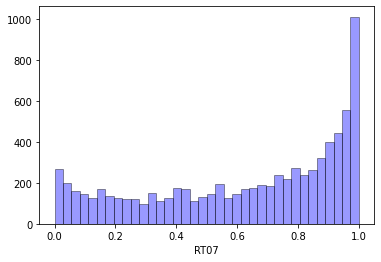

In [12]:
sns.distplot(dataset2['RT07'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='RT09'>

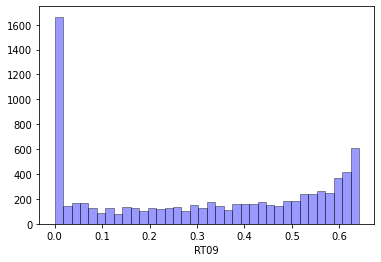

In [13]:
sns.distplot(dataset2['RT09'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

In [14]:
dataset3 = copy.deepcopy(dataset2)  

In [15]:
dataset3 = dataset3[dataset3['PercentageChange']<=.1]

In [16]:
dataset3['TrueRiskTolerance'] = (dataset3['RT07'] + dataset3['RT09'])/2

In [17]:
dataset3.drop(labels=['RT07', 'RT09'], axis=1, inplace=True)
dataset3.drop(labels=['PercentageChange'], axis=1, inplace=True)

## The following are the key intuitive features that will be retained for further modelling:
* AGE: There are 6 age categories, where 1 represents age less than 35 and 6 represents age more than 75.
* EDUC: There are 4 education categories, where 1 represents no high school and 4 represents college degree.
* MARRIED: It represents marital status. There are two categories where 1 represents married and 2 represents unmarried.
* OCCU: It represents occupation category. 1 represents managerial category and 4 represents unemployed.
* KIDS: It represents number of kids.
* NWCAT: It represents net worth category. There are 5 categories, where 1 net worth less than 25 percentile and 5 represents net worth more than 90th percentile.
* INCCL: It represents income category. There are 5 categories, where 1 income less than 10,000 and 5 represents net worth more than 100,000
* RISK: It represents the willingness to take risk on a scale of 1 to 4, where 1 represents highest level of willingness to take risk.

In [18]:
keep_list2 = ['AGE07','EDCL07','MARRIED07','KIDS07','OCCAT107','INCOME07','RISK07','NETWORTH07','TrueRiskTolerance'
]

drop_list2 = [col for col in dataset3.columns if col not in keep_list2]

dataset3.drop(labels=drop_list2, axis=1, inplace=True)

<AxesSubplot:title={'center':'Correlation Matrix'}>

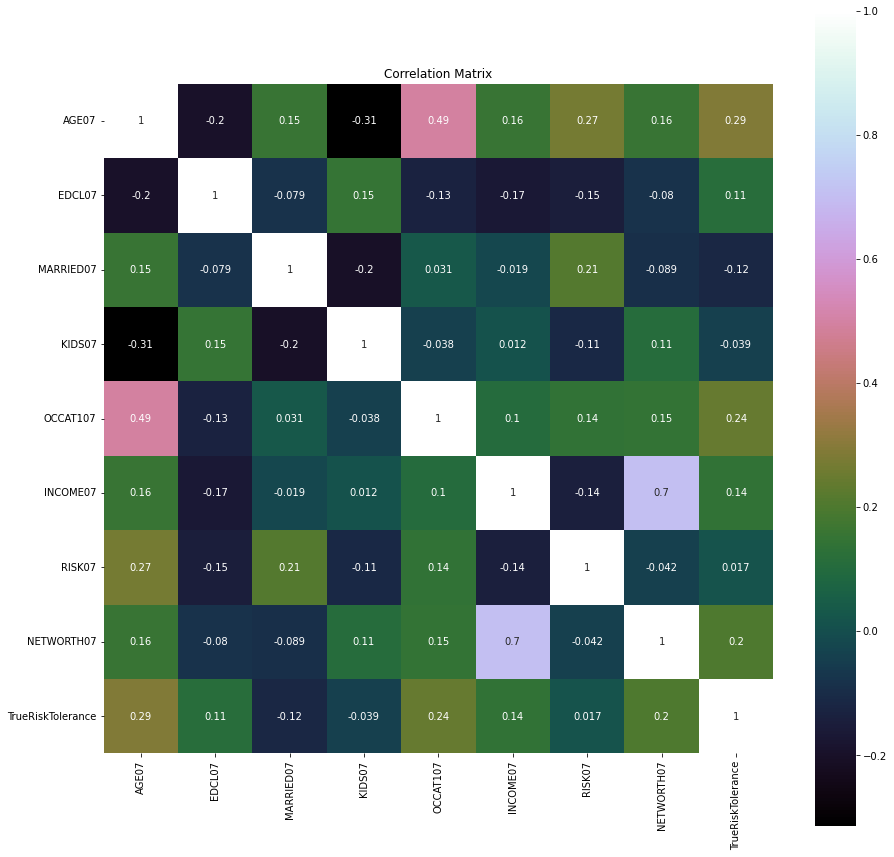

In [19]:
# correlation
correlation = dataset3.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1080x1080 with 0 Axes>

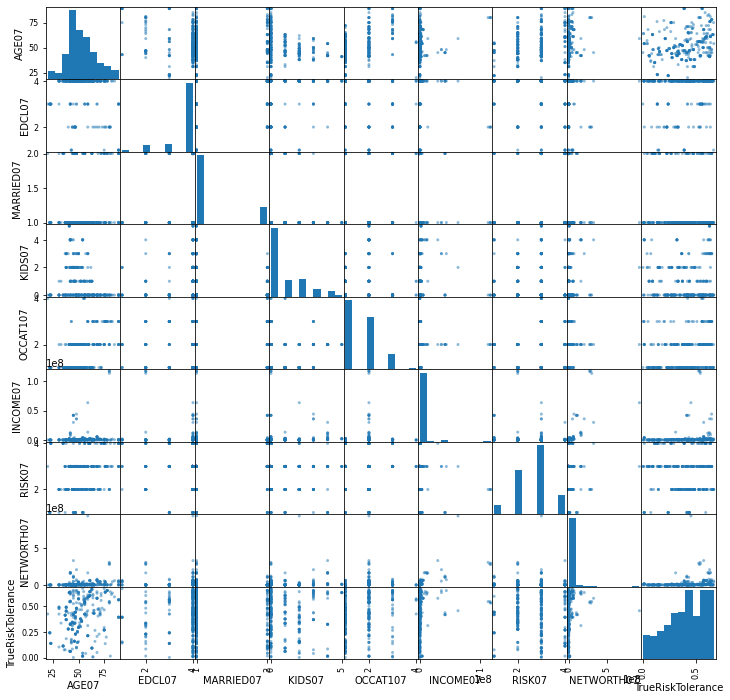

In [20]:
# Scatterplot Matrix
from pandas.plotting import scatter_matrix
plt.figure(figsize=(15,15))
scatter_matrix(dataset3,figsize=(12,12))
plt.show()

## Train Test Split

In [21]:
# split out validation dataset for the end
Y= dataset3["TrueRiskTolerance"]
X = dataset3.loc[:, dataset3.columns != 'TrueRiskTolerance']
# scaler = StandardScaler().fit(X)
# rescaledX = scaler.transform(X)
validation_size = 0.2
seed = 3
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [22]:
# test options for regression
num_folds = 10
#scoring = 'neg_mean_squared_error'
#scoring ='neg_mean_absolute_error'
scoring = 'r2'

## Comparing Models/Algorithms with K-fold Cross Validation

In [23]:
# spot check the algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
#Neural Network
#models.append(('MLP', MLPRegressor()))
#Ensable Models 
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [24]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.105127 (0.103969)
LASSO: -0.023692 (0.118324)
EN: -0.031108 (0.117770)
KNN: -0.409466 (0.166879)
CART: -0.566303 (0.164437)
SVR: -0.101482 (0.092744)
ABR: -0.402677 (0.084476)
GBR: -0.650102 (0.104161)
RFR: -0.736366 (0.079853)
ETR: -0.752701 (0.118432)


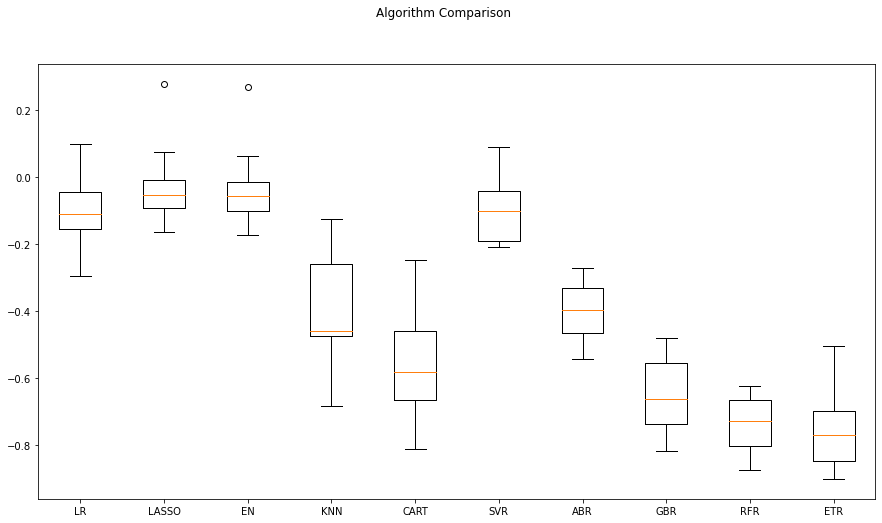

In [25]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

## Model Tuning & Grid Search on the best model (i.e. RandomForest)

In [26]:
# 8. Grid search : RandomForestRegressor 
'''
n_estimators : integer, optional (default=10)
    The number of trees in the forest.
'''
param_grid = {'n_estimators': [50,100,150,200,250,300,350,400]}
model = RandomForestRegressor()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.741536 using {'n_estimators': 200}
0.737718 (0.077397) with: {'n_estimators': 50}
0.729351 (0.084204) with: {'n_estimators': 100}
0.734122 (0.087629) with: {'n_estimators': 150}
0.741536 (0.075538) with: {'n_estimators': 200}
0.738243 (0.083984) with: {'n_estimators': 250}
0.735689 (0.084542) with: {'n_estimators': 300}
0.736351 (0.082858) with: {'n_estimators': 350}
0.731559 (0.084571) with: {'n_estimators': 400}


In [27]:
# prepare model
model = RandomForestRegressor(n_estimators = 250)
model.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=250)

In [28]:
from sklearn.metrics import r2_score
predictions_train = model.predict(X_train)
print(r2_score(Y_train, predictions_train))

0.9661144700417595


In [29]:
# estimate accuracy on validation set
# transform the validation dataset
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(X_validation)
print(mean_squared_error(Y_validation, predictions))
print(r2_score(Y_validation, predictions))

0.007742677848910578
0.7626499886405267


## Feature Importance

[0.22345849 0.02557914 0.01371534 0.04735036 0.02369033 0.23235288
 0.05223969 0.38161377]


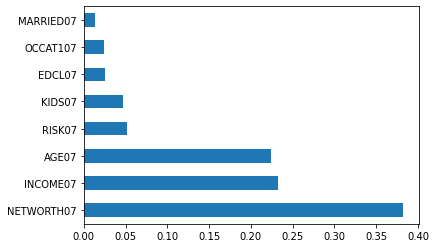

In [30]:
import pandas as pd
import numpy as np
model = RandomForestRegressor(n_estimators= 200,n_jobs=-1)
model.fit(X_train,Y_train)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

## Saving the final model

In [31]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'finalized_model.sav'
dump(model, open(filename, 'wb'))

In [32]:
# load the model from disk
loaded_model = load(open(filename, 'rb'))
# estimate accuracy on validation set
predictions = loaded_model.predict(X_validation)
result = mean_squared_error(Y_validation, predictions)
print(r2_score(Y_validation, predictions))
print(result)

0.7712508500091739
0.007462106137878649


# Conclusion:
Thus, we could objectively ascertain investors' "true" risk tolerance, which plays crucial role in determining the suitable assets and the corresponding allocations thereby helping clients reach their financial goals in a more scientific way. 